In [105]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import os
%matplotlib inline

In [148]:
def plot_faces(faces):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(faces[np.random.randint(1,45)].reshape(64,64),'gray')

In [149]:
def read_images(path):
    imdata=[]
    for i in range(45):
        x=os.path.join(path,str(i+1)+".png")
        im=cv.cvtColor(cv.imread(x),cv.COLOR_RGB2GRAY)
        im=np.reshape(im,newshape=(im.shape[0]*im.shape[1]))
        imdata.append(im)
    return np.array(imdata)
imdata=read_images("./train")
imdata.shape

(45, 4096)

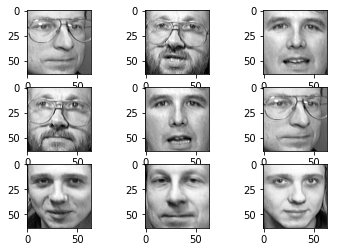

In [150]:
plot_faces(imdata)

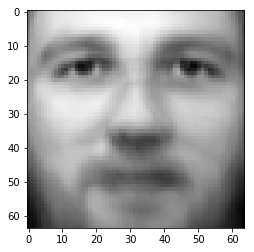

In [151]:
def get_mean_face(x):
    mean_face=np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        mean_face[i]=x[:,i].mean()
    return mean_face

mean_face=get_mean_face(imdata)
plt.imshow(mean_face.reshape(64,64),'gray')

In [110]:
def get_mean_zero_face(faces,mean):
    newfaces=np.zeros(shape=faces.shape)
    for i in range(faces.shape[0]):
        newfaces[i]=faces[i]-mean
    return newfaces
mean_zero_face=get_mean_zero_face(imdata,mean_face)
mean_zero_face.shape

(45, 4096)

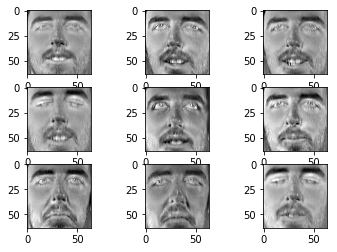

In [111]:
plot_faces(mean_zero_face)

In [112]:
variance_matrix=np.matmul(mean_zero_face,mean_zero_face.T)
variance_matrix.shape

(45, 45)

In [153]:
eigenvalue,eigenvectors=np.linalg.eig(variance_matrix)
eigenvalue.shape,eigenvectors.shape

((45,), (45, 45))

In [155]:
args=np.argsort(eigenvalue)
args=args[::-1]
eigenvalue=eigenvalue[args]
eigenvectors=eigenvectors[:,args]

In [181]:
#select top k features
topkfeatures=eigenvectors[:,:20]
topkfeatures.shape

(45, 20)

In [182]:
eigenfaces=np.matmul(topkfeatures.T,mean_zero_face)
eigenfaces.shape

(20, 4096)

In [183]:
signaturefaces=np.matmul(eigenfaces,mean_zero_face.T)
signaturefaces.shape

(20, 45)

#### LDA

In [184]:
def withinClass(signature_faces): #finding within class scatter
    data = np.zeros(shape = (20 , 20))
    for i in range(5):
        mat = signature_faces[ : , i * 5 : (i+1) * 5] #taking images of each class
        mn = mat.mean(axis = 1) #taking mean of those images
        rows ,cols = mat.shape 
        mn = mn.reshape(rows , 1)
        mat = mat - mn 
        mul = np.dot(mat , mat.T) 
        data += mul 
    return data

In [185]:
def betweenClass(signature_faces): #finding between class scatter
    data = np.zeros(shape = (20 , 20))
    mean = signature_faces.mean(axis = 1) 
    mean = mean.reshape(20 , 1) 
    for i in range(5):
        mat = signature_faces[ : , i * 5 : (i+1) * 5] #taking images of each class
        mn = mat.mean(axis = 1) #taking mean of those images
        rows ,cols = mat.shape
        mn = mn.reshape(rows , 1)
        meandiff = mn - mean 
        mul = np.dot(meandiff , mn.T) 
        data += mul 
    return data

In [186]:
wcs = withinClass(signaturefaces)
bcs = betweenClass(signaturefaces)
wcs.shape,bcs.shape

((20, 20), (20, 20))

In [187]:
def computeJ(wcs , bcs):  
    return (np.dot(np.linalg.inv(wcs) , bcs)) 
J = computeJ(wcs , bcs)
J.shape

(20, 20)

In [190]:
eigen_values , eigen_vectors = np.linalg.eig(J) 
indices = eigen_values.argsort()[::-1]
eigen_values = eigen_values[indices]
eigen_vectors = eigen_vectors[: , indices]
eigen_values.shape,eigen_vectors.shape

((20,), (20, 20))

In [192]:
features = eigen_vectors[:, 0:10].T 
features.shape , mean_zero_face.shape

((10, 20), (45, 4096))

In [194]:
fisher_face = np.dot(features , signaturefaces) 
fisher_face = fisher_face.T
fisher_face.shape

(45, 10)

#### testing 

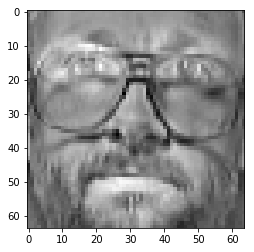

In [195]:
testimage=cv.cvtColor(cv.imread("./test/z4.png"),cv.COLOR_RGB2GRAY)
testimage=np.reshape(testimage,newshape=(1,64*64))
test_mean_face=get_mean_zero_face(testimage,mean_face)
plt.imshow(test_mean_face.reshape(64,64),'gray')

In [199]:
test_face=np.matmul(eigenfaces,test_mean_face.T)
test_face=np.matmul(features,test_face)
test_face.shape

(10, 1)

In [200]:
mindist=np.inf
minidx=0
idx=0
for c in fisher_face:
    c=c.reshape(test_face.shape)
    dist=np.linalg.norm(c-test_face,axis=0)
    if(dist<mindist):
        mindist=dist
        minidx=idx
    idx+=1

In [201]:
print(mindist,(minidx//9)+1)

[1029782.41936555] 4
